In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import glob

from tqdm import tqdm
import seaborn as sns
from collections import Counter

import cv2

In [80]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

#import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

In [81]:
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors

In [82]:
train = pd.read_csv("/kaggle/happywhale/input/train.csv")
train.shape

(51033, 3)

In [83]:
train.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [84]:
from sklearn.preprocessing import normalize
from scipy.spatial import distance

In [85]:
import pickle

def load_emb(exp_names,pickle_name):
    # train/valid   train_all/test
    emb_lis = []
    for exp in exp_names:
        with open(exp + '/' + pickle_name + '.pickle', 'rb') as f:
            valid_preds = pickle.load(f)
        emb_lis.append(valid_preds)
    
    return normalize(np.concatenate(emb_lis,axis=1))
        

In [86]:
import pickle

def load_emb_weighted(exp_names,pickle_name,weights):
    # train/valid   train_all/test
    emb_lis = []
    for exp,w in zip(exp_names,weights):
        with open(exp + '/' + pickle_name + '.pickle', 'rb') as f:
            valid_preds = pickle.load(f)
        valid_preds *= w
        emb_lis.append(valid_preds)
    
    return normalize(np.concatenate(emb_lis,axis=1))
        

In [87]:
exps = [
    "aws_exp000","aws_exp001","aws_exp002","aws_exp003","aws_exp004", # backfin
    "exp093","exp098","exp099","exp100","exp101", # fullbody
    "aws_exp006","aws_exp007","aws_exp008","aws_exp009","aws_exp010", # ensemble
    "aws_exp022","aws_exp023","aws_exp024","aws_exp025","aws_exp026", # backfin_ensemble_species
]


In [88]:
def get_map(valid_preds, train_preds,valid_df,train_df):

    distances = cuml.metrics.pairwise_distances(valid_preds,train_preds)

    K=min(1000,len(train_df)-1)
    predicted_positions = np.argpartition(distances, K, axis=1)[:, :K]

    score_lis = []
    pred_ids = []
    corredt_ids  = []
    hit_species=defaultdict(int)
    count_species=defaultdict(int)

    train_inddividual_id_lis = train_df["individual_id"].values
    valid_inddividual_id_lis = valid_df["individual_id"].values

    rank_lis=[]

    for i in tqdm(range(predicted_positions.shape[0])):
        nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
        nearest.sort(key=lambda x: x[1])

        prediction = [index_id for index_id, d in nearest]

        done = set()
        pred_list = []
        for pred_id in prediction:
            if pred_id in done:
                continue
            done.add(pred_id)
            pred_list.append(pred_id)
            if len(pred_list)==5:
                break
        pred_ids.append(pred_list)

        if valid_inddividual_id_lis[i] in pred_list:
            s = 1/(pred_list.index(valid_inddividual_id_lis[i]) + 1)
            score_lis.append(s)
            rank_lis.append(pred_list.index(valid_inddividual_id_lis[i]))
        else:
            score_lis.append(0)
            rank_lis.append(5)

        
    return score_lis

In [89]:
def get_score(species,exps,weights):
    train_preds = load_emb_weighted(exps,"train",weights)
    valid_preds = load_emb_weighted(exps,"valid",weights)
    
    species_train_df = train_df.query("species in @species")
    species_valid_df = valid_df_for_train.query("species in @species")

    train_preds = train_preds[species_train_df.index]
    valid_preds = valid_preds[species_valid_df.index]
    
    return get_map(valid_preds,train_preds,species_valid_df,species_train_df)

In [90]:
result_df_4 = pd.read_csv("species_aware_weighted_average_0410_fold_4.csv")
result_df_3 = pd.read_csv("species_aware_weighted_average_0410_fold_3.csv")
result_df_2 = pd.read_csv("species_aware_weighted_average_0410_fold_2.csv")
result_df_1 = pd.read_csv("species_aware_weighted_average_0410_fold_1.csv")
result_df_0 = pd.read_csv("species_aware_weighted_average_0410_fold_0.csv")

In [91]:
print(result_df_3.shape)
print(result_df_4.shape)

(13, 6)
(13, 6)


In [92]:
result_df_3.head()

,species,backfin,fullbody,ensemble,backfin_ensemble_spe,best
0,blue_whale,1,1.465360,0.168429,0.935920,0.555499
1,beluga,1,2.596000,1.372231,2.232109,0.749679
2,gray_whale,1,1.064472,1.384008,0.976345,0.814644
3,dusky_dolphin,1,0.073506,2.683978,3.160473,0.846173
4,fin_whale,1,2.784410,1.687675,1.855458,0.899628


In [93]:
result_df = pd.DataFrame()

result_df["species"]  = result_df_0["species"]
result_df["backfin"]  = 1

keys=["fullbody","ensemble","backfin_ensemble_spe"]
for key in keys:
    result_df[key] = (result_df_4[key] + result_df_3[key] + result_df_2[key] + result_df_1[key] + result_df_0[key] )/5


In [94]:
result_df

,species,backfin,fullbody,ensemble,backfin_ensemble_spe
0,blue_whale,1,1.226488,0.273253,1.051474
1,beluga,1,2.990707,1.761358,2.541736
2,gray_whale,1,2.299246,1.937649,1.513071
3,dusky_dolphin,1,1.349014,2.078466,2.662497
4,fin_whale,1,1.990634,1.931170,2.722879
5,humpback_whale,1,1.473838,1.200309,1.280695
6,spinner_dolphin,1,1.768820,1.174592,3.141465
7,melon_headed_whale,1,1.690318,0.616334,2.103005
8,killer_whale,1,0.880743,1.452757,1.350579
9,minke_whale,1,1.389732,1.905574,2.565786


### test

In [95]:
test_df =pd.read_csv("../input/sample_submission.csv")
test_df.shape

(27956, 2)

In [96]:
test_preds      = load_emb(exps,"test")
train_all_preds = load_emb(exps,"train_all")

In [97]:
print(test_preds.shape)
print(train_all_preds.shape)

(27956, 10240)
(51033, 10240)


### predict nearest species

In [98]:
from sklearn.metrics import pairwise_distances

In [99]:
%%time

distances = pairwise_distances(test_preds,train_all_preds)

CPU times: user 14min 11s, sys: 5min 48s, total: 20min
Wall time: 1min 42s


In [100]:
%%time

K=1
predicted_positions = np.argpartition(distances, K, axis=1)[:, :K]

CPU times: user 4.19 s, sys: 5.8 s, total: 9.99 s
Wall time: 10 s


In [101]:
predicted_positions.shape

(27956, 1)

In [102]:
train_species_lis = train.species.values
test_pred_species = []


for i in range(len(predicted_positions)):
    train_species = train_species_lis[predicted_positions[i]][0]
    test_pred_species.append(train_species)

In [103]:
test_df["species"] = test_pred_species

In [104]:
Counter(test_pred_species)

Counter({'gray_whale': 647,
         'false_killer_whale': 1782,
         'beluga': 4324,
         'humpback_whale': 4569,
         'dusky_dolphin': 2256,
         'melon_headed_whale': 1119,
         'bottlenose_dolphin': 4416,
         'spinner_dolphin': 1313,
         'cuviers_beaked_whale': 371,
         'southern_right_whale': 659,
         'blue_whale': 1166,
         'killer_whale': 1560,
         'pygmy_killer_whale': 52,
         'fin_whale': 832,
         'long_finned_pilot_whale': 193,
         'sei_whale': 279,
         'pantropic_spotted_dolphin': 91,
         'minke_whale': 557,
         'common_dolphin': 194,
         'spotted_dolphin': 360,
         'short_finned_pilot_whale': 837,
         'white_sided_dolphin': 153,
         'brydes_whale': 100,
         'commersons_dolphin': 80,
         'frasiers_dolphin': 4,
         'rough_toothed_dolphin': 42})

In [105]:
test_df.head()

,image,predictions,species
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,gray_whale
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,false_killer_whale
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,beluga
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,humpback_whale
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,dusky_dolphin


### weighted

In [106]:
species_count_valid_df = pd.read_csv("species_count_valid_df.csv")
species_count_valid_df.shape
minor_species = species_count_valid_df[species_count_valid_df["count"] <= 100].species.values
len(minor_species)

13

In [107]:
test_preds      = load_emb(exps,"test")
train_all_preds = load_emb(exps,"train_all")

In [108]:
print(test_preds.shape)
print(train_all_preds.shape)

(27956, 10240)
(51033, 10240)


In [109]:
emb_all_len = train_all_preds.shape[1]
fold_emb_len = 512*5

In [110]:
result_df

,species,backfin,fullbody,ensemble,backfin_ensemble_spe
0,blue_whale,1,1.226488,0.273253,1.051474
1,beluga,1,2.990707,1.761358,2.541736
2,gray_whale,1,2.299246,1.937649,1.513071
3,dusky_dolphin,1,1.349014,2.078466,2.662497
4,fin_whale,1,1.990634,1.931170,2.722879
5,humpback_whale,1,1.473838,1.200309,1.280695
6,spinner_dolphin,1,1.768820,1.174592,3.141465
7,melon_headed_whale,1,1.690318,0.616334,2.103005
8,killer_whale,1,0.880743,1.452757,1.350579
9,minke_whale,1,1.389732,1.905574,2.565786


In [111]:
spe_lis = list(set(result_df.species))

for spe in  spe_lis:
   # print(spe)
    if spe in minor_species or spe=="frasiers_dolphin":
        #weight = np.array([1] * emb_all_len)       
        continue

    backfin=1
    fullbody=result_df.query("species == @spe").iloc[0].fullbody
    ensemble=result_df.query("species == @spe").iloc[0].ensemble
    backfin_ensemble=result_df.query("species == @spe").iloc[0].backfin_ensemble_spe
        
    weight=[backfin] * fold_emb_len + [fullbody] * fold_emb_len + [ensemble] * fold_emb_len  + [backfin_ensemble] * fold_emb_len 
    
    train_ind = train.query("species == @spe").index
    test_ind = test_df.query("species == @spe").index
    
    train_all_preds[train_ind] *= weight
    test_preds[test_ind] *= weight

In [112]:
train_all_preds=normalize(train_all_preds)
test_preds=normalize(test_preds)

In [113]:
train_all_preds.shape, test_preds.shape

((51033, 10240), (27956, 10240))

ensemble

In [114]:
import bz2
import pickle
import _pickle as cPickle

def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f:
        cPickle.dump(data, f)
        
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [115]:
team_files = [
    "exp16v6AugmixB3_fold0.pbz2",
    "exp16v6AugmixB3_fold1.pbz2",
    "exp16v6AugmixB3_fold2.pbz2",
    "exp16v6AugmixB3_fold3.pbz2",
    "exp16v6AugmixB3_fold4.pbz2",
    "exp16v6AugmixB4Step2_fold0.pbz2",
    "exp16v6AugmixB4Step2_fold1.pbz2",
    "exp16v6AugmixB4Step2_fold2.pbz2",
    "exp16v6AugmixB4Step2_fold3.pbz2",
    "exp16v6AugmixB4Step2_fold4.pbz2",
    "exp16v6Augmix_fold0.pbz2",
    "exp16v6Augmix_fold1.pbz2",
    "exp16v6Augmix_fold2.pbz2",
    "exp16v6Augmix_fold3.pbz2",
    "exp16v6Augmix_fold4.pbz2",
    "exp21b6_fold0.pbz2",
    "exp16v4sampler_fold0.pbz2",
]

In [116]:
fold2 = pd.read_csv("/kaggle/happywhale/input/whale-21-3-2022/fold2.csv")
fold2.shape

(51033, 8)

In [117]:
fold2_dict=dict()

fold2_images = fold2.image.values

for i in range(len(fold2)):
    fold2_dict[fold2_images[i]] = i

new_index = []
org_train_image=train.image.values

for i in range(len(train)):
    new_index.append(fold2_dict[org_train_image[i]])
    

In [119]:
def get_embeddings(files):
    
    DIRNAME ="../input/whale-21-3-2022/"
    data = decompress_pickle("../input/whale-21-3-2022/exp16v6AugmixB4Step2_fold4.pbz2")
    
    train_emb_lis = []
    test_emb_lis  = []
    
    for fname in files:
        print(fname)
        data = decompress_pickle(DIRNAME + fname)
        
        train_emb = normalize(data["emb_val"][new_index,:],axis=1)
        test_emb  = normalize(data["emb_test"],axis=1)

        train_emb_lis.append(train_emb)
        test_emb_lis.append(test_emb)
        
        print("    ",train_emb.shape,test_emb.shape)
    
    ret_train = normalize(np.concatenate(train_emb_lis,axis=1))
    ret_test  = normalize(np.concatenate(test_emb_lis,axis=1))
        
    return ret_train,ret_test
    

In [120]:
train_emb,test_emb = get_embeddings(team_files)

exp16v6AugmixB3_fold0.pbz2
     (51033, 512) (27956, 512)
exp16v6AugmixB3_fold1.pbz2
     (51033, 512) (27956, 512)
exp16v6AugmixB3_fold2.pbz2
     (51033, 512) (27956, 512)
exp16v6AugmixB3_fold3.pbz2
     (51033, 512) (27956, 512)
exp16v6AugmixB3_fold4.pbz2
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold0.pbz2
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold1.pbz2
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold2.pbz2
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold3.pbz2
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold4.pbz2
     (51033, 512) (27956, 512)
exp16v6Augmix_fold0.pbz2
     (51033, 512) (27956, 512)
exp16v6Augmix_fold1.pbz2
     (51033, 512) (27956, 512)
exp16v6Augmix_fold2.pbz2
     (51033, 512) (27956, 512)
exp16v6Augmix_fold3.pbz2
     (51033, 512) (27956, 512)
exp16v6Augmix_fold4.pbz2
     (51033, 512) (27956, 512)
exp21b6_fold0.pbz2
     (51033, 512) (27956, 512)
exp16v4sampler_fold0.pbz2
     (51033, 512) (27956, 512)


In [121]:
train_emb.shape, test_emb.shape

((51033, 8704), (27956, 8704))

In [122]:
new_train_emb = np.hstack([train_all_preds,train_emb])

In [123]:
new_test_emb = np.hstack([test_preds,test_emb])

In [124]:
new_train_emb.shape, new_test_emb.shape

((51033, 18944), (27956, 18944))

In [125]:
new_train_emb = normalize(new_train_emb,axis=1)

In [126]:
new_test_emb = normalize(new_test_emb,axis=1)

In [127]:
%%time

distances = pairwise_distances(new_test_emb,new_train_emb)

CPU times: user 26min 7s, sys: 10min 19s, total: 36min 27s
Wall time: 3min


In [128]:
%%time

K=1000
predicted_positions = np.argpartition(distances, K, axis=1)[:, :K]

CPU times: user 11.5 s, sys: 4.89 s, total: 16.4 s
Wall time: 16.4 s


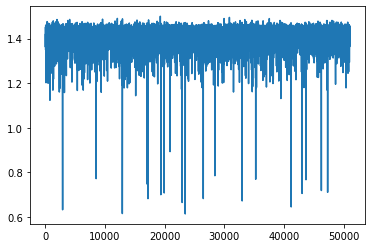

In [129]:
plt.plot(distances[0])

In [130]:
sub_pred_lis = []

train_inddividual_id_lis = train["individual_id"].values


for i in tqdm(range(predicted_positions.shape[0])):
    nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
    nearest.sort(key=lambda x: x[1])

    prediction = [index_id for index_id, d in nearest]
    
    done = set()
    pred_list = []
    for pred_id in prediction:
        if pred_id in done:
            continue
        done.add(pred_id)
        pred_list.append(pred_id)
        if len(pred_list)==5:
            break    

            
    sub_pred_lis.append(pred_list)

100%|██████████| 27956/27956 [00:30<00:00, 914.14it/s]


In [131]:
pred_lis_joined = []
for preds in sub_pred_lis:
    pred_lis_joined.append(" ".join(preds))

In [132]:
test_df["predictions"] = pred_lis_joined

In [133]:
test_df[["image","predictions"]].to_csv("submission_weighted_" +"_".join(exps)+ ".csv",index=None)

In [135]:
test_df

,image,predictions,species
0,000110707af0ba.jpg,fbe2b15b5481 6d1cc6d00dca 5ec416e8a0a1 24e212e...,gray_whale
1,0006287ec424cb.jpg,1424c7fec826 c3b7d902e73c f0efb5bcc5d3 e72a502...,false_killer_whale
2,000809ecb2ccad.jpg,1ce3ba6a3c29 82f26bb1adae d3cedf439859 c0fd946...,beluga
3,00098d1376dab2.jpg,c4274d90be60 2781acdf5508 b5db2ecef12d 8b7c290...,humpback_whale
4,000b8d89c738bd.jpg,cf500d3874bc d4d2cd407a48 56637d420170 396610a...,dusky_dolphin
...,...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef 843297d1983b ec0aa394b7e5 5b64c9d...,spinner_dolphin
27952,fff8fd932b42cb.jpg,539541f81a32 4e376cb4fd38 b7bd57892597 d02966c...,dusky_dolphin
27953,fff96371332c16.jpg,dc4082105594 2fad3a13934d 9d86367bdff7 8949de1...,beluga
27954,fffc1c4d3eabc7.jpg,a8fe10f7b3e0 e7f9e93184b9 d85f2d5186cb fd53cdc...,cuviers_beaked_whale


### set new_individual_cnt

In [136]:
#test_new_ind_cnt_df = pd.read_csv("../input/test_new_ind_ratio_0328.csv")
test_new_ind_cnt_df = pd.read_csv("../input/test_new_ind_ratio_0402.csv")

In [137]:
spe_lis = test_new_ind_cnt_df.species.values

In [138]:
test_new_ind_cnt_df

,species,test_new_ind_ratio
0,humpback_whale,0.097941
1,bottlenose_dolphin,0.025106
2,beluga,0.006468
3,dusky_dolphin,0.523474
4,false_killer_whale,0.015609
5,killer_whale,0.017829
6,spinner_dolphin,0.064464
7,blue_whale,0.048034
8,melon_headed_whale,0.376427
9,fin_whale,0.101046


In [139]:
def get_thr(spe,ratio_target_df,top1=True,multiplier=1.0):
    spe_ind_lis = test_df.query("species == @spe").index.values
    sub_pred_lis=[]
    
    for i in spe_ind_lis:
        nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
        nearest.sort(key=lambda x: x[1])

        prediction = [index_id for index_id, d in nearest]
        dists = [d for index_id, d in nearest]

        done = set()
        dist_list = []
        for pred_id,dist in zip(prediction,dists):
            if pred_id in done:
                continue
            done.add(pred_id)
            dist_list.append(dist)
            if len(dist_list)==5:
                break    


        sub_pred_lis.append(dist_list)
    
    
    
    ratio_target = multiplier * ratio_target_df.query("species == @spe").iloc[0]["test_new_ind_ratio"]
    
    return binary(sub_pred_lis,ratio_target,top1)

In [140]:
def solve(sub_pred_lis,mid,target_ratio):
    ratio_lis = []
    for i in range(len(sub_pred_lis)):
        ratio = 0
        for j in range(5):
            if sub_pred_lis[i][j] > mid: # j is new_ind
                ratio = 1/(j+1)
                break
        
        ratio_lis.append(ratio)
    return np.mean(ratio_lis) < target_ratio

def solve_top1(sub_pred_lis,mid,target_ratio):
    ratio_lis = []
    for i in range(len(sub_pred_lis)):
        ratio = 0
        for j in range(5):
            if sub_pred_lis[i][0] > mid: 
                ratio = 1
                break
        
        ratio_lis.append(ratio)
    return np.mean(ratio_lis) < target_ratio

def binary(sub_pred_lis,target_ratio,top1):
    ok=2
    ng=0
    cnt=0
    while cnt<100:
        cnt+=1
        mid = (ok+ng)/2
        #ret = solve(sub_pred_lis,mid,target_ratio)
        if top1:
            ret = solve_top1(sub_pred_lis,mid,target_ratio)
        else:
            ret = solve(sub_pred_lis,mid,target_ratio)
            
        if ret:
            ok=mid
        else:
            ng=mid
    return ok

In [141]:
get_thr("beluga",test_new_ind_cnt_df,top1=True,multiplier=0.5)

1.2056779861450195

In [142]:
MULTIPLIER=1.3

In [143]:
thr_lis_top1 = []
for spe in tqdm(spe_lis):
    thr = get_thr(spe,test_new_ind_cnt_df,top1=True,multiplier=MULTIPLIER)
    thr_lis_top1.append(thr)

100%|██████████| 26/26 [00:52<00:00,  2.00s/it]


In [144]:
thr_df = pd.DataFrame()
thr_df["species"] = spe_lis
thr_df["thr"] = thr_lis_top1


In [145]:
thr_df

,species,thr
0,humpback_whale,1.122491
1,bottlenose_dolphin,1.082591
2,beluga,1.182442
3,dusky_dolphin,0.916115
4,false_killer_whale,1.073289
5,killer_whale,1.123395
6,spinner_dolphin,1.056865
7,blue_whale,1.145641
8,melon_headed_whale,0.935094
9,fin_whale,1.073631


In [146]:
sub_pred_lis = []

train_inddividual_id_lis = train["individual_id"].values
new_ind_1_cnt=0

new_ind_index_lis = [] # 1, 0.5 ,0.33, 0.25, 0.2

for i in tqdm(range(predicted_positions.shape[0])):
    nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
    
    nearest.sort(key=lambda x: x[1])
    
    spe = test_pred_species[i]
    new_individual_thr = thr_df.query("species == @spe").iloc[0].thr

    done = set()
    pred_list = []
    new_ind_ind = 0
    for pred_id, score in nearest:
        if score > new_individual_thr and not "new_individual" in done:
            pred_list.append("new_individual")
            done.add("new_individual")
            new_ind_index_lis.append(1/len(pred_list))
            
        if pred_id in done:
            continue
        done.add(pred_id)
        pred_list.append(pred_id)
        if len(pred_list)>=5:
            break    

    if pred_list[0]=="new_individual":
        new_ind_1_cnt+=1
    sub_pred_lis.append(pred_list[:5])

100%|██████████| 27956/27956 [01:06<00:00, 417.51it/s]


In [147]:
new_ind_1_cnt/len(test_df)

0.14293890399198741

In [148]:
np.mean(new_ind_index_lis)

0.5196090027928372

In [149]:
pred_lis_joined = []
for preds in sub_pred_lis:
    pred_lis_joined.append(" ".join(preds))

In [150]:
test_df["predictions"] = pred_lis_joined

In [151]:
test_df[["image","predictions"]].to_csv("submission_multi_" +str(MULTIPLIER)+".csv",index=None)

In [152]:
test_df

,image,predictions,species
0,000110707af0ba.jpg,fbe2b15b5481 new_individual 6d1cc6d00dca 5ec41...,gray_whale
1,0006287ec424cb.jpg,1424c7fec826 c3b7d902e73c new_individual f0efb...,false_killer_whale
2,000809ecb2ccad.jpg,1ce3ba6a3c29 82f26bb1adae d3cedf439859 c0fd946...,beluga
3,00098d1376dab2.jpg,c4274d90be60 2781acdf5508 b5db2ecef12d 8b7c290...,humpback_whale
4,000b8d89c738bd.jpg,cf500d3874bc new_individual d4d2cd407a48 56637...,dusky_dolphin
...,...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef 843297d1983b new_individual ec0aa...,spinner_dolphin
27952,fff8fd932b42cb.jpg,new_individual 539541f81a32 4e376cb4fd38 b7bd5...,dusky_dolphin
27953,fff96371332c16.jpg,dc4082105594 2fad3a13934d 9d86367bdff7 8949de1...,beluga
27954,fffc1c4d3eabc7.jpg,new_individual a8fe10f7b3e0 e7f9e93184b9 d85f2...,cuviers_beaked_whale


In [161]:
lb0852=pd.read_csv("rank_ensemble_0852.csv")
lb0843=pd.read_csv("lb0843.csv")

In [162]:
lb0843

,image,predictions
0,000110707af0ba.jpg,fbe2b15b5481 new_individual 6d1cc6d00dca 5ec41...
1,0006287ec424cb.jpg,1424c7fec826 c3b7d902e73c new_individual f0efb...
2,000809ecb2ccad.jpg,1ce3ba6a3c29 82f26bb1adae d3cedf439859 c0fd946...
3,00098d1376dab2.jpg,c4274d90be60 2781acdf5508 b5db2ecef12d 8b7c290...
4,000b8d89c738bd.jpg,cf500d3874bc new_individual d4d2cd407a48 56637...
...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef 843297d1983b new_individual ec0aa...
27952,fff8fd932b42cb.jpg,new_individual 539541f81a32 4e376cb4fd38 b7bd5...
27953,fff96371332c16.jpg,dc4082105594 2fad3a13934d 8949de1830d1 9d86367...
27954,fffc1c4d3eabc7.jpg,new_individual a8fe10f7b3e0 e7f9e93184b9 d85f2...


In [163]:
same_count=0
diff_count=0
for i in range(len(sub_pred_lis)):
    top1_team = sub_pred_lis[i][0]
    top1_sub = lb0843.predictions.values[i].split()[0]
    

    if top1_team==top1_sub:
        same_count+=1
    else:
        diff_count+=1

In [164]:
same_count

27698

In [165]:
diff_count

258